# Gravitational Wave Polarization Classification
This project uses **machine learning** to classify gravitational wave signals into three polarization modes: Tensor (0), Vector (1), Scalar (2).

Using Bayesian evidence ratios (logZ values) from waveform comparisons to as the features of each simulation.

## Data Preparation
We start with three datasets containing simulation results for different polarization types. Each contains:
- Signal parameters (RA, Dec, SNR)
- Bayesian evidences (logZ) for different polarization models
- Localization information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

In [2]:
plt.rcParams['figure.figsize'] = (6, 4)
RANDOM_STATE = 42

In [3]:
# read data
tsummary = pd.read_csv('tsummary.txt')
vsummary = pd.read_csv('vsummary.txt')
ssummary = pd.read_csv('ssummary.txt')
#print(tsummary.columns)

# encoding
tsummary['polarization'] = 0
vsummary['polarization'] = 1
ssummary['polarization'] = 2
#print(tsummary.columns)

# Drop NaN values
print(tsummary.shape)
tsummary = tsummary.dropna()
print(tsummary.shape)

print(vsummary.shape)
vsummary = vsummary.dropna()
print(vsummary.shape)

print(ssummary.shape)
ssummary = ssummary.dropna()
print(ssummary.shape)

# Combine datasets
summary = pd.concat([tsummary, vsummary, ssummary], axis=0, ignore_index=True)
print(summary.shape)
print(f'Min SNR: {summary.snr.min()}')

(200, 22)
(199, 22)
(200, 37)
(199, 37)
(200, 37)
(200, 37)
(598, 37)
Min SNR: 1.186369953884686


We create physics-informed features from the Bayesian evidence values:
- Differences between logZ values of different models
- Signal-to-noise ratio (SNR) filtering (≥8 for clear signals)


In [4]:
# Clean and filter data
def preprocess_data(summary):
    
    # Remove low SNR events
    summary = summary[summary['snr'] >= 8]
    
    # Create evidence difference features
    df = pd.DataFrame()
    df['btnvn'] = summary['logZ-tensor-N-0']-summary['logZ-vector-N-0']
    df['btrvr'] = summary['logZ-tensor-R-1']-summary['logZ-vector-R-1']
    df['btrsn'] = summary['logZ-tensor-R-1']-summary['logZ-scalar-N-0']
    df['btnsp'] = summary['logZ-tensor-N-0']-summary['logZ-scalar-P-1']
    df['bvrsn'] = summary['logZ-vector-R-1']-summary['logZ-scalar-N-0']
    df['bvnsp'] = summary['logZ-vector-N-0']-summary['logZ-scalar-P-1']
    df['snr'] = summary['snr']
    df['polarization'] = summary['polarization']
    
    df = shuffle(df)
    
    return df

In [5]:
processed_summary = preprocess_data(summary)
print(np.argwhere(np.isnan(processed_summary.values)))
print(f"Final dataset size: {len(processed_summary)} simulations")
processed_summary

[]
Final dataset size: 503 simulations


,btnvn,btrvr,btrsn,btnsp,bvrsn,bvnsp,snr,polarization
468,0.143315,-0.754770,-0.220524,-0.860934,0.534246,-1.004249,14.644487,2
355,-0.010332,-5.984617,0.465227,4.314331,6.449845,4.324663,20.861204,1
538,0.000633,0.661906,-0.134970,-0.637209,-0.796876,-0.637842,14.161207,2
312,0.360764,0.147762,0.017709,0.339139,-0.130053,-0.021624,10.818097,1
103,-0.406632,-0.694045,-0.254718,1.888509,0.439327,2.295141,20.151291,0
...,...,...,...,...,...,...,...,...
529,-0.020407,0.003164,0.034601,-0.288375,0.031437,-0.267968,8.765280,2
392,-0.146313,-1.896744,-5.380489,2.400101,-3.483745,2.546415,24.198099,1
456,-1.649974,9.098542,-0.240613,-0.841744,-9.339155,0.808230,20.589514,2
332,-1.834843,-7.454058,-21.338358,-0.871054,-13.884299,0.963789,35.142448,1


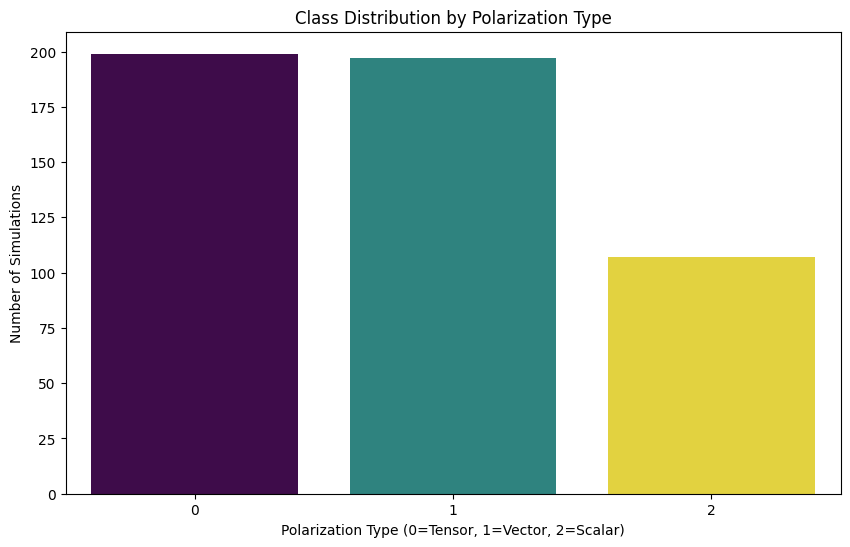

"\n# Plot feature distributions\ng = sns.PairGrid(processed_summary, hue='polarization', palette='viridis')\ng.map_upper(sns.scatterplot, alpha=0.6)\ng.map_lower(sns.kdeplot)\ng.map_diag(sns.histplot, kde=True)\ng.add_legend()\nplt.suptitle('Feature Distributions and Relationships', y=1.02)\nplt.show()\n"

In [6]:
# Plot class distribution
plt.figure(figsize=(10,6))
sns.countplot(x='polarization', data=processed_summary,
              hue='polarization', palette='viridis', legend=False)
plt.title('Class Distribution by Polarization Type')
plt.xlabel('Polarization Type (0=Tensor, 1=Vector, 2=Scalar)')
plt.ylabel('Number of Simulations')
plt.show()

'''
# Plot feature distributions
g = sns.PairGrid(processed_summary, hue='polarization', palette='viridis')
g.map_upper(sns.scatterplot, alpha=0.6)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True)
g.add_legend()
plt.suptitle('Feature Distributions and Relationships', y=1.02)
plt.show()
'''

## Machine Learning Models
We'll compare two models:
1. Logistic Regression
2. Random Forest

In [7]:
# Prepare data
X = processed_summary.drop(['polarization'], axis=1)
y = processed_summary['polarization']

# Split data - stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def evaluate_model(model, X_test, y_test):
    # Print accuracy and confusion matrix
    y_pred = model.predict(X_test)
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    
    fig, ax = plt.subplots(figsize=(10,7))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=['Tensor', 'Vector', 'Scalar'],
        cmap='Blues', ax=ax
    )
    plt.title('Confusion Matrix')
    plt.show()

### 1. Logistic Regression

---Logistic regression model---
Accuracy: 0.72


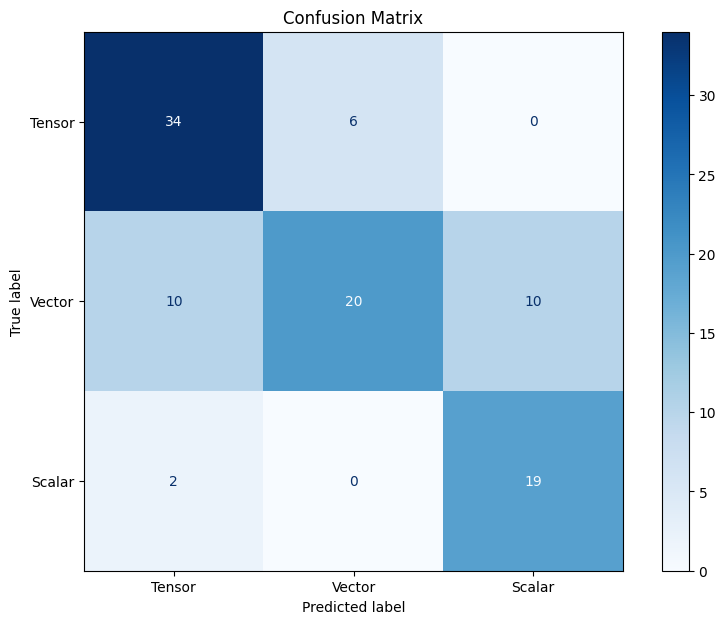

In [ ]:
lr_model = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)

print('---Logistic regression model---')
evaluate_model(lr_model, X_test, y_test)

### 2. Random Forest

---Random forest model---
Accuracy: 0.76


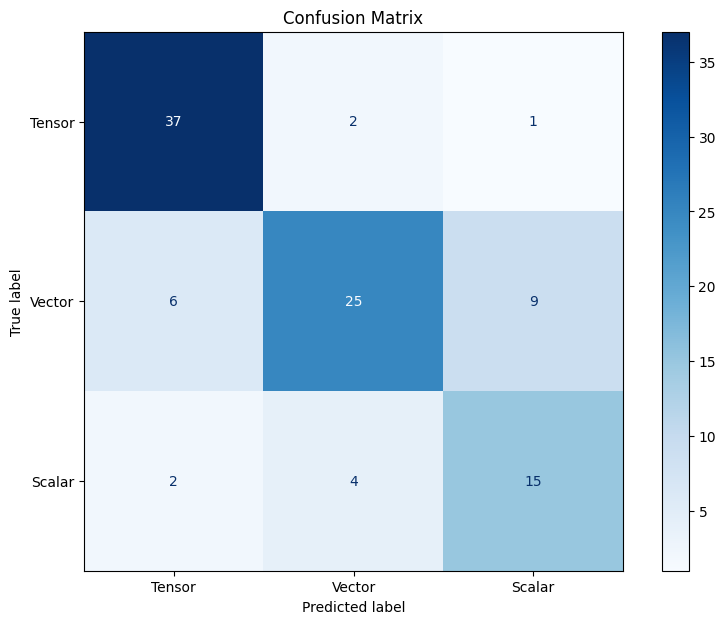

In [ ]:

rf_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

print('---Random forest model---')
evaluate_model(rf_model, X_test, y_test)

In [ ]:
# save the model to file
from joblib import dump
dump(lr_model, 'logisticreg_gwpl_model.joblib')
dump(rf_model, 'randomforest_gwpl_model.joblib')